In [2]:
pip install lime


📘 X_train_scaled (first 5 rows):
        BVP       EDA      TEMP      AccX      AccY      AccZ        HR  \
0 -3.637107 -0.640298 -1.000436  1.394057 -0.646130  1.189580 -0.551251   
1  0.179808 -0.658935  0.727069 -0.420363 -1.194035  0.154585  0.276302   
2 -0.210431  0.885215 -0.520573 -0.280793  0.527954  0.622002 -0.306659   
3  0.002711 -0.671679  1.004322 -0.746029  0.606226  0.187972  0.778055   
4  7.028627  1.978133  1.398876 -1.118217 -0.606993 -1.013957  0.036544   

      Delta     Theta    Alpha1    Alpha2     Beta1     Beta2    Gamma1  \
0 -0.543635  2.613001 -0.521736  0.382069 -0.379010 -0.168772  8.611543   
1 -0.445946 -0.545911  0.495684 -0.675699 -0.678930  0.440231 -0.451797   
2 -0.295491 -0.201855 -0.510869 -0.537818 -0.722953  0.909343  0.180146   
3 -0.499958 -0.311743  0.238484  0.314970  4.912600 -0.537903 -0.353875   
4 -0.704435 -0.489852 -0.651057  0.049133  0.844237 -0.027085  0.134743   

     Gamma2   Attention   Meditation  
0 -0.503361   -0.173077  

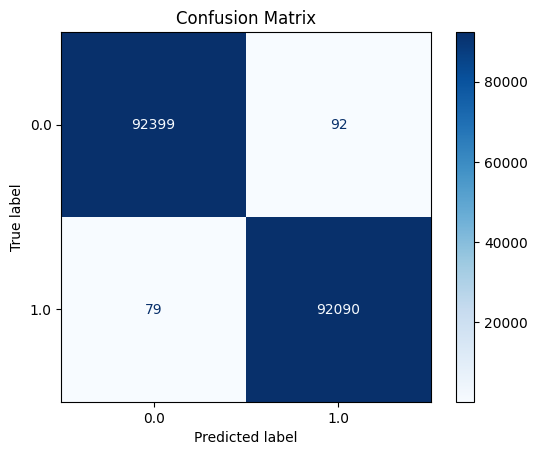

   Sample  Predicted_Class  Uncertainty (1 - max prob)
0       0              1.0                         0.0
1       1              1.0                         0.0
2       2              1.0                         0.0
3       3              1.0                         0.0
4       4              0.0                         0.0


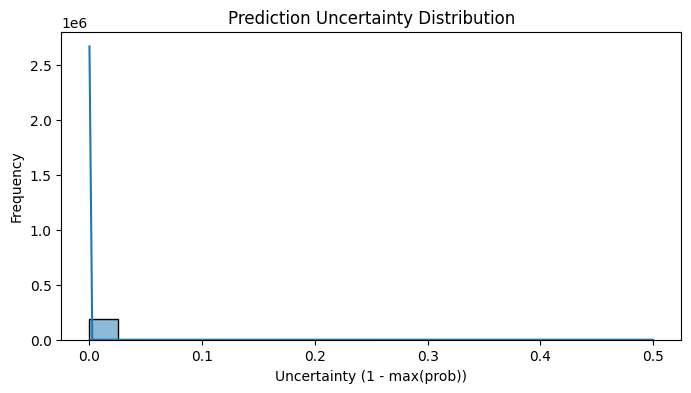


🟡 LIME Explanation for First Sample:
[('TEMP <= -0.46', 0.17357405851908225), ('-0.65 < EDA <= -0.43', -0.11498389999583739), ('AccY > 0.49', -0.06325495886171346), ('HR <= -0.69', 0.033608541162554406), (' Beta1 <= -0.65', -0.025668880852149262), (' Beta2 <= -0.65', 0.022370407587997933), ('0.03 < BVP <= 0.33', 0.02206187551246886), (' Alpha1 <= -0.66', 0.017799163363200043), ('-0.14 < AccX <= 0.56', 0.016389460520111355), ('0.25 < AccZ <= 0.82', -0.01602489047958847)]


 96%|=================== | 193/200 [00:23<00:00]       

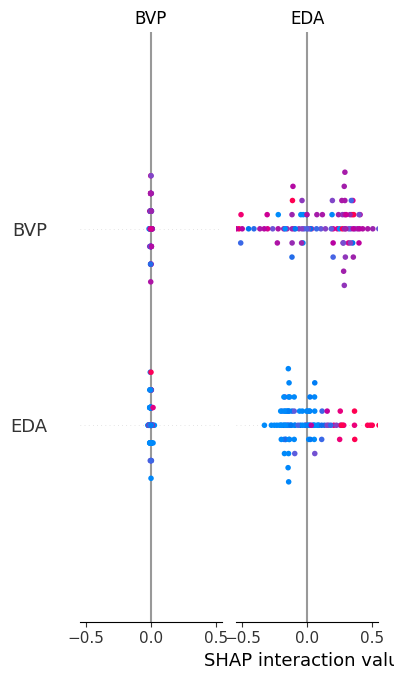


✅ Results saved to 'M5Prime_Classifier_Results.xlsx'


In [3]:
# oselm_uncertainty_xai.py with M5 Prime Classifier integration

import pandas as pd
import numpy as np
import shap
import matplotlib.pyplot as plt
import seaborn as sns
from lime.lime_tabular import LimeTabularExplainer
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    matthews_corrcoef, confusion_matrix, classification_report,
    ConfusionMatrixDisplay
)
from sklearn.tree import DecisionTreeClassifier
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.utils.validation import check_X_y, check_array, check_is_fitted

import warnings
warnings.filterwarnings("ignore")


class M5PrimeClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, min_samples_split=20):
        self.min_samples_split = min_samples_split
        self.tree = DecisionTreeClassifier(min_samples_split=self.min_samples_split)
        self.leaf_class_votes = {}

    def fit(self, X, y):
        X, y = check_X_y(X, y)
        self.tree.fit(X, y)
        self.classes_ = np.unique(y)
        leaves = self.tree.apply(X)
        self.leaf_class_votes = {}
        for leaf in np.unique(leaves):
            idx = np.where(leaves == leaf)[0]
            if len(idx) > 0:
                values, counts = np.unique(y[idx], return_counts=True)
                self.leaf_class_votes[leaf] = dict(zip(values, counts))
        return self

    def predict(self, X):
        check_is_fitted(self)
        X = check_array(X)
        leaves = self.tree.apply(X)
        preds = []
        for leaf in leaves:
            votes = self.leaf_class_votes.get(leaf, {})
            if votes:
                pred_class = max(votes, key=votes.get)
            else:
                pred_class = self.tree.classes_[0]
            preds.append(pred_class)
        return np.array(preds)

    def predict_proba(self, X):
        check_is_fitted(self)
        X = check_array(X)
        leaves = self.tree.apply(X)
        proba = np.zeros((X.shape[0], len(self.classes_)))
        for i, leaf in enumerate(leaves):
            votes = self.leaf_class_votes.get(leaf, {})
            total = sum(votes.values())
            for cls, count in votes.items():
                proba[i, np.where(self.classes_ == cls)[0][0]] = count / total
        return proba


def compute_uncertainty(probs):
    return 1 - np.max(probs, axis=1)


def main():
    data = pd.read_csv("/content/drive/MyDrive/CODE/Prince Okyere/MID/MEFAR_MID.csv")
    data.dropna(inplace=True)
    label_encoder = LabelEncoder()
    data['class'] = label_encoder.fit_transform(data['class'])
    classes = label_encoder.classes_.astype(str)

    X = data.drop('class', axis=1)
    y = data['class']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    model = M5PrimeClassifier(min_samples_split=10)
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    y_pred_probs = model.predict_proba(X_test_scaled)

    # Convert scaled features to DataFrames
    X_train_df = pd.DataFrame(X_train_scaled, columns=X.columns)
    X_test_df = pd.DataFrame(X_test_scaled, columns=X.columns)

    # Convert predictions to DataFrames
    y_pred_df = pd.DataFrame({"Predicted_Class": y_pred})
    y_pred_probs_df = pd.DataFrame(
        y_pred_probs,
        columns=[f"Class_{cls}" for cls in label_encoder.classes_]
    )

    # Display head of each DataFrame
    print("\n📘 X_train_scaled (first 5 rows):")
    print(X_train_df.head())

    print("\n📗 X_test_scaled (first 5 rows):")
    print(X_test_df.head())

    print("\n📙 y_pred (first 5 rows):")
    print(y_pred_df.head())

    print("\n📕 y_pred_probs (first 5 rows):")
    print(y_pred_probs_df.head())


    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, average='weighted')
    rec = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    mcc = matthews_corrcoef(y_test, y_pred)
    report = classification_report(y_test, y_pred, target_names=classes)
    cm = confusion_matrix(y_test, y_pred)

    print("\n📊 Classification Report:\n", report)

    youden_index = np.nan
    if cm.shape == (2, 2):
        tn, fp, fn, tp = cm.ravel()
        specificity = tn / (tn + fp)
        sensitivity = recall_score(y_test, y_pred)
        youden_index = sensitivity + specificity - 1

    ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes).plot(cmap='Blues')
    plt.title("Confusion Matrix")
    plt.show()

    uncertainties = compute_uncertainty(y_pred_probs)
    uncertainty_df = pd.DataFrame({
        "Sample": np.arange(len(uncertainties)),
        "Predicted_Class": label_encoder.inverse_transform(y_pred),
        "Uncertainty (1 - max prob)": uncertainties
    })
    print(uncertainty_df.head())

    plt.figure(figsize=(8, 4))
    sns.histplot(uncertainties, bins=20, kde=True)
    plt.title("Prediction Uncertainty Distribution")
    plt.xlabel("Uncertainty (1 - max(prob))")
    plt.ylabel("Frequency")
    plt.show()

    lime_exp = LimeTabularExplainer(X_train_scaled, feature_names=X.columns,
                                    class_names=classes, discretize_continuous=True)
    lime_result = lime_exp.explain_instance(X_test_scaled[0], model.predict_proba, num_features=10)
    print("\n🟡 LIME Explanation for First Sample:")
    print(lime_result.as_list())

    rf = RandomForestClassifier()
    rf.fit(X_train_scaled, y_train)

    explainer = shap.Explainer(rf, X_train_scaled)
    shap_values = explainer(X_test_scaled[:100])
    shap.summary_plot(shap_values, X_test.iloc[:100], show=True)


    results_df = pd.DataFrame({
        "Metric": ["Accuracy", "Precision", "Recall", "F1 Score", "MCC", "Youden Index"],
        "Value": [acc, prec, rec, f1, mcc, youden_index]
    })
    results_df.to_excel("M5Prime_Classifier_Results.xlsx", index=False)
    print("\n✅ Results saved to 'M5Prime_Classifier_Results.xlsx'")


if __name__ == "__main__":
    main()
